# Fast exponential and softmax functions

Based on the bit manupulation of the IEEE 754 floating point numbers.
See N. N. Schraudolph, “A Fast, Compact Approximation of the Exponential Function,” Neural Computation, vol. 11, no. 4, pp. 853–862, May 1999, doi: 10.1162/089976699300016467.

A 32-bit floating point number is given by:
$$ x = (-1)^s (1+m)2^{e-127} $$
where $s$ - sign bit; $m$ - 23-bit mantissa; $e$ - 8-bit exponent;

For bit layout see [this diagram](https://upload.wikimedia.org/wikipedia/commons/d/d2/Float_example.svg).

Writing some integer value $i$ in bit field of the exponent and read back as a float number will give $2^{i-127}$. 

So shifting the value $x+127$ by 23 bit, dividing by $\ln(2)$ and reading back as $e^x$. Correction factor $C$ allows adjusting the approximation for some parameters.

$$f(x) = 2^{23} \left(\frac{x}{\ln(2)} + 127 - C\right)$$
In some example following approximation is used with specific values in code $C = 0.057985$:
```C
uint32_t value = (1<<23)*(1.4426950409*x+126.94201519f);
```
Which is then bitcast to floating point number via union type punning.


## Softmax

Softmax is a function over a vector $\mathbf{X}$:

$$ \sigma(\mathbf{X})_i = \frac{e^{x_i}}{\sum\limits_{j=0}^{N}e^{x_j}} $$


When calculating softmax the maximum is substracted from initial data for numerical stability - to avoid overflows.



C = 0.057985


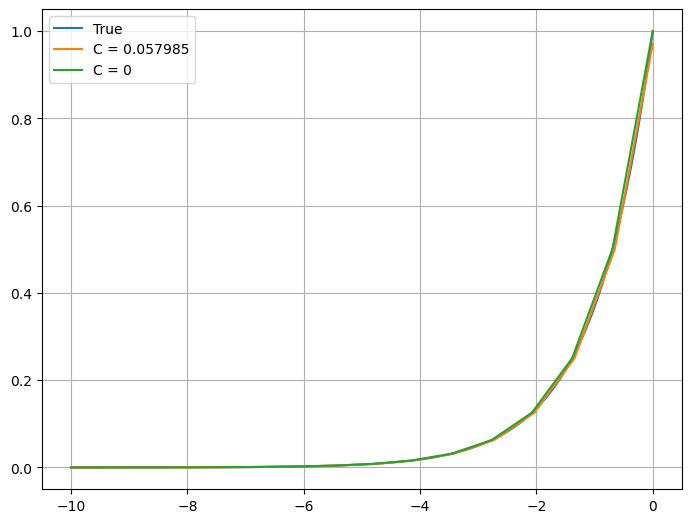

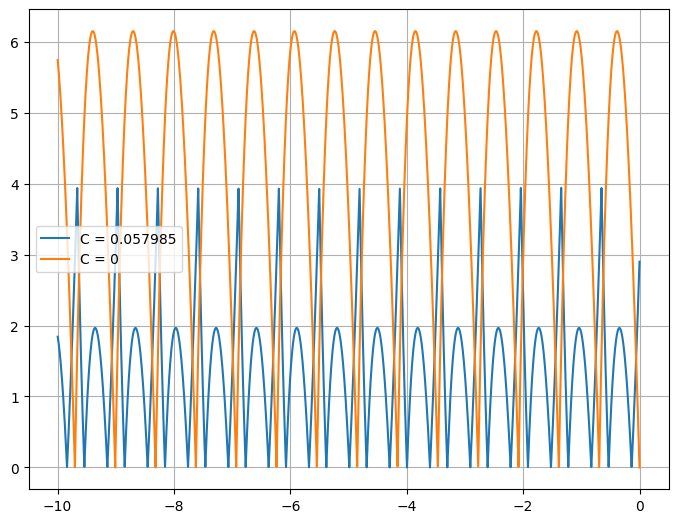

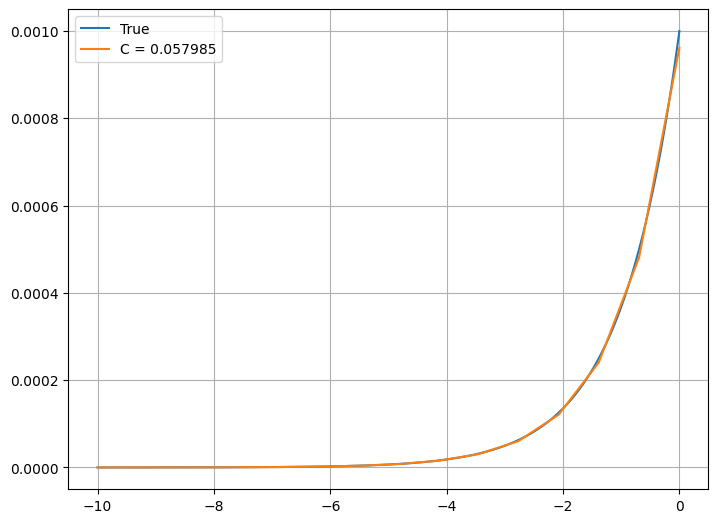

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import struct

SIZE = 10000

C = 127 - 126.94201519

print("C = {:f}".format(127 - 126.94201519))

def fast_exp(x, c=0):
    A = np.float32(1.4426950409)*np.ones((SIZE), np.float32)
    K = np.float32(1 << 23)*np.ones((SIZE), np.float32)
    y = np.multiply(K,(A*x+127 - c),dtype='f')
    z = np.int32(y)
    v = z.view(np.float32)
    return v

def softmax(x, func):
    exps = func(x)
    sums = np.sum(exps)
    return func(x)/sums

def fast_2x(x, c=0):
    K = np.float32(1 << 23)*np.ones((SIZE), np.float32)
    y = np.multiply(K,(x+127 - c),dtype='f')
    z = np.int32(y)
    v = z.view(np.float32)
    return v

x = np.linspace(-10, 0, SIZE, dtype=np.float32)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(x, np.exp(x))
ax.plot(x, fast_exp(x, C))
ax.plot(x, fast_exp(x))
ax.grid(True)
ax.legend(["True", "C = 0.057985", "C = 0"])

err_fig = plt.figure()
err_ax = err_fig.add_axes([0, 0, 1, 1])
err_ax.grid(True)
err_ax.plot(x, 100*np.abs(np.exp(x) - fast_exp(x, C)) / np.exp(x))
err_ax.plot(x, 100*np.abs(np.exp(x) - fast_exp(x)) / np.exp(x))
err_ax.legend(["C = 0.057985", "C = 0"])

sm_fig = plt.figure()
sm_ax = sm_fig.add_axes([0, 0, 1, 1])
data = x
sm_ax.plot(data, softmax(data, np.exp))
sm_ax.plot(data, softmax(data, fast_exp))
sm_ax.grid(True)
sm_ax.legend(["True", "C = 0.057985"])

